# Motivations AAA method

In this notebook, we demonstrate some limitations of the original allometric aggregation method, motivating the changes we made which led to our adapted AA method.

In [43]:
import numpy as np

from lib import helpers
from lib import complexity
from lib import activity_counts

In [19]:
patient_id = 7

In [20]:
df = helpers.read_counts(patient_id)

## Polynomial and spreading

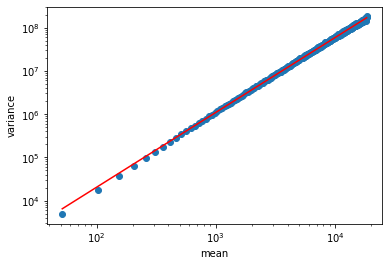

In [21]:
fractal_dim = complexity.allometric_aggregation(np.array(df["counts"]), 6*60)

The left-most point on the plot is obtained for a scale n = 1 (this is the mean and variance of the original sequence). As we move to the right, n increases, meaning more and more samples are aggregated into blocks, as we effectively zoom out to higher scales. The right-most point on the plot (though it is not clearly visible), represents the mean and variance of the sequence which is created when 9 hours worth of datapoints are summed block per block. 

The fractal dimension is calculated by measuring the **slope** of the linear relation between the mean and variance. However, it is clear from the plot that this relation is not approximated well by a straight line. If we were to fit a straight line to the left part of the relation (which represents the behaviour at scales in the minute-range), it would have a different slope than the one that is obtained now. For this reason, the AAA method opts to fit a polynomial relation to the datapoints, instead of fitting a straight line. By extracting the local slope, we can obtain the fractal dimension which represents the fractal correlations present in the activity sequence for any scaling range. 

Also note that the slope which is extracted by the original method, is most representative for higher scales. As we can see from the plot, there are much more datapoints located at the right hand side of the plot than on the left. This is of course due to the logarithmic scale of the plot, but it does mean that the method which tries to fit the polynomial would pay much more attention to these higher scales than the lower ones. In order to obtain an accurate estimation of the fractal dimension at all desired scales, the polynomial should fit well in all areas of the curve. For this reason, another adaptation is made to the algorithm: instead of considering all values of n lying in between n_min and n_max, the datapoints are **spread out** exponentially within this interval. The extent of this spreading is controlled through the s parameter in the AAA algorithm. Compare, for example, the following two outcomes: 

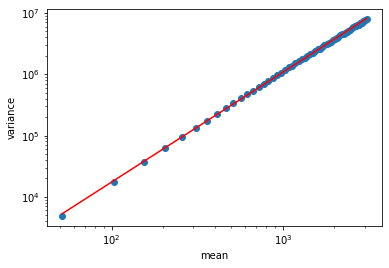

In [22]:
fractal_dim = complexity.allometric_aggregation(np.array(df["counts"]), 60)

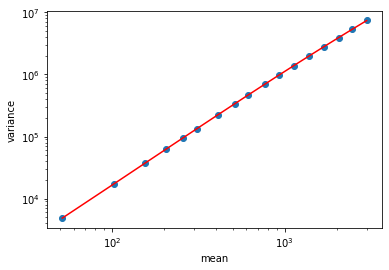

In [23]:
fractal_dim, scales = complexity.adapted_allometric_aggregation(np.array(df["counts"]), 1, 60, s=1.2)

One can clearly observe that the datapoints are spread out in a more equidistant way in the second plot (AAA method), compared to the first plot (original AA method). This will allow the fitted polynomial to be less biased towards higher scales, obtaining an accurate slope for a large range of scales. 

## Overlapping segments

In the original AA method, the segments in which n datapoints are aggregated (summed) do not overlap. This is clear from the formulas below, which illustrate the procedure followed by the AA method. 
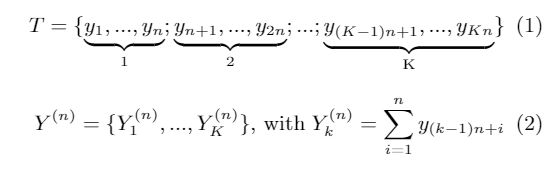
In this representation, it is assumed that a subdivision of the original sequence into K blocks of exactly size n is always possible. In practice, this will never be possible for all values of n. This means that the last block in the newly aggregated sequence usually contains less than n samples, instead of exactly n samples. This can lead to instabilities in the method. To illustrate this, we define an alternative implementation of the original AA method which returns the calculated means and variances, next to the obtained fractal dimension. 

In [31]:
import scipy.stats as stats
import matplotlib.pyplot as plt
# same as the method in "complexity.py", just returns "means" and "variances" as well now
def allometric_aggregation(seq, n_max, draw=True):
    """
    The original allometric aggregation algorithm as defined by West. Returns the fractal dimension of a time series 
    and the log-log plot from which this was extracted.

    :param seq: numpy array of equidistant signal values, in our case 1-minute activity counts sequence
    :param n_max: maximal level of aggregation
    :param draw: a boolean indicating whether or not to draw the log-log plot and the estimated slope, default value True

    return: the fractal dimension of the sequence (float), as well as the calculated means and variances
    """

    # perform aggregation for n (number of aggregated data points) ranging from 1 to n_max
    means = np.zeros(n_max)
    variances = np.zeros(n_max)

    for n in range(1, n_max + 1):

        rescaled = []
        i = 0
        # all blocks except for maybe the last one will aggregate n datapoints,
        # the last block aggregates the remainder of the data points, which is not always equal to n
        # this can lead to end effects, which make the method unstable when applied to shorter sequences
        while i < len(seq):
            agg = sum(seq[i:i+n])
            rescaled.append(agg)
            i += n
        # calculate mean and variance for all levels of aggregation
        means[n-1] = np.mean(rescaled)
        variances[n-1] = np.var(rescaled)

    # calculate slope of relation between mean and variance
    b, a, r_value, p_value, std_err = stats.linregress(np.log(means), np.log(variances))

    # draw fitted line
    if (draw):
        fig, ax = plt.subplots(1)
        plt.scatter(means, variances)
        plt.plot(means, np.exp(a) * means ** b, color='red')
        ax.set_yscale("log")
        ax.set_xscale("log")
        plt.xlabel("mean")
        plt.ylabel("variance")

    # calculate fractal dimension
    D = 2 - b / 2

    return D, means, variances

We will now illustrate the instabilities which can occur in the method by considering a single day in the patient's activity sequence. For illustration purposes, we first aggregate the counts into 5-minute intervals instead of 1-minute intervals (the instabilities still occur on the 1-minute counts as well, but using 5-minute counts results in a smaller number of datapoints on the plot, making the illustration more clear).

In [44]:
day_activity = df["2021-03-22 06:00":"2021-03-23 05:55"]
counts_5min = activity_counts.aggregate_counts(day_activity, "5T")

In [45]:
fract_dim, means, variances = allometric_aggregation(np.array(counts_5min["counts"]), 3*12, draw=False)

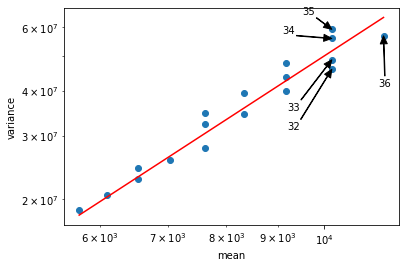

In [46]:
b, a, r_value, p_value, std_err = stats.linregress(np.log(means), np.log(variances))

fig, ax = plt.subplots(1)
plt.scatter(means[18:], variances[18:])
plt.plot(means[18:], np.exp(a) * means[18:] ** b, color='red')
ax.set_yscale("log")
ax.set_xscale("log")
plt.xlabel("mean")
plt.ylabel("variance")

plt.annotate(text=36, xy=(means[-1], variances[-1]), xycoords = "data", xytext=(-5, -50), textcoords="offset points", arrowprops = dict(facecolor='black', width=0.5, headwidth=7, headlength=8))
plt.annotate(text=35, xy=(means[-2], variances[-2]), xycoords = "data", xytext=(-30, 15), textcoords="offset points", arrowprops = dict(facecolor='black', width=0.5, headwidth=7, headlength=8))
plt.annotate(text=34, xy=(means[-3], variances[-3]), xycoords = "data", xytext=(-50, 5), textcoords="offset points", arrowprops = dict(facecolor='black', width=0.5, headwidth=7, headlength=8))
plt.annotate(text=33, xy=(means[-4], variances[-4]), xycoords = "data", xytext=(-45, -50), textcoords="offset points", arrowprops = dict(facecolor='black', width=0.5, headwidth=7, headlength=8))
plt.annotate(text=32, xy=(means[-5], variances[-5]), xycoords = "data", xytext=(-45, -60), textcoords="offset points", arrowprops = dict(facecolor='black', width=0.5, headwidth=7, headlength=8))

plt.show()

The plot above is annotated with the segment sizes (parameter n in the algorithm) for which the last 5 means and variances on the plot were obtained. Starting from block size 32, it seems that the mean of the formed sequence remains constant for a while, while the variance increases as the block size increases. Suddenly, a jump in the mean occurs for block size 36, the highest block size (corresponding to a scale of 3 hours in this case). If the algorithm were to continue from this point onward by further increasing n, the variances would again spread out around the mean obtained for block size 36, until a jump in the mean occurs again and the cycle starts anew.

The total length of the counts sequence contained in the 24-hour window, denoted as N, is 288 (the counts are aggregated into 5-minute intervals before entering the algorithm, leading to 24 times 12 samples in the sequence). The allometric aggregation algorithm divides the sequence into segments of size n, for n running from 1 to n_max. As mentioned, N is not always exactly divisible by any n between 1 and n_max. This means that the last block in the newly aggregated sequence usually contains less than n samples. For example, when n is equal to 32, 9 blocks will be formed, all containing exactly 32 samples. However, when n is equal to 33, 9 blocks will be formed once more, but only 8 of these will contain 33 samples, while the last one contains only 24. Even though the mean is the same in both cases (all 288 datapoints are summed and divided by 9, the number of blocks), the variance is overestimated in the second case. When blocks of 34 samples are formed, the last segment will contain even less samples (only 16), increasing the variance even more. This goes on until the total number of datapoints is divisible by n again, which is the case for n equal to 36. 

When the total length N of the sequence is not divisible by n, the variance gets overestimated compared to the mean obtained at that point. This impacts the slope of the straight line which is fitted to the plot, eventually leading to an incorrect estimation of the fractal dimension. The segment at the end which is only partially filled has a larger share in the calculation of the variance when there are less segments in total. As n grows, less and less segments are formed, and the error between the estimated mean-variance datapoint and the "real" mean-variance datapoint (though it is unknown what this would be) grows larger. Even though the problem is present at all scales, it only gets problematic and significantly disturbs the fractal dimension when n_max approaches a similar order of magnitude as the full length of the considered sequence. This is the case when our maximal scale is 9 hours and the window is 3 days (which are the parameters set in the evolution method). 

Now, consider the outcome of the adapted allometric aggregation method for the same activity sequence. Again, we slightly change the method so it also returns the means and variances it obtained:

In [50]:
import numpy.polynomial.polynomial as poly
# same as complexity.adapted_allometric_aggregation, but also returns the means and variances 
def adapted_allometric_aggregation(seq, n_min, n_max, s=1.1, draw=True):
    """
    The adapted allometric aggregation algorithm. Returns the fractal dimension of a time series for various scales 
    and the log-log plot from which these were extracted. We draw attention to the changes that were made compared to the original
    allometric aggregation algorithm in the comments. 

    :param seq: numpy array of equidistant signal values, in our case 1-minute activity counts sequence
    :param n_min: minimal level of aggregation
    :param n_max: maximal level of aggregation
    :param s: factor controlling the spread of the aggregation levels within the interval [n_min, n_max], default value 1.1
    :param draw: a boolean indicating whether or not to draw the log-log plot and the estimated polynomial, default value True

    return: the fractal dimension of the sequence (float) for every level n in scales
    """

    means = []
    variances = []
    scales = []
    n = n_min # the first aggregation step aggregates n_min samples
    
    while n <= n_max:

        step = max(1, int(n/16)) # some overlap is now allowed in the aggregated segments of size n
                                    # if step would be equal to n, we would allow no overlap like in the original AA algorithm
                                    # now, step is at least 16 times smaller than n, generating 16 times more segments 
                                    # (now partially overlapping) to estimate mean and var from
        rescaled = []
        i = 0
        
        while i < len(seq)-n+step: # every segment always contains n samples, except for the last one, which contains at least 15/16*n samples
                                    # this ensures a reliable calculation of the mean and variance, avoiding end effects
            agg = sum(seq[i:i+n])
            rescaled.append(agg)
            i += step # sliding window moves forward with steps smaller than n, allowing the segments to overlap
        
        means.append(np.mean(rescaled))
        variances.append(np.var(rescaled))
        scales.append(n) # keep track of the scales we explored within the interval [n_min, n_max]
        
        n = int(np.ceil(n*s)) # increase aggregation level n with factor s to ensure even spreading of the 
                                # mean-variance datapoints on the log-log plot
                                # this makes the fit of the polynomial better adjusted to all scales, rather than biased towards the higher scales

    means = np.array(means)
    variances = np.array(variances)

    # fit third-order polynomial to the means and variances in log-log space
    fitted_poly = poly.Polynomial.fit(np.log(means), np.log(variances), 3)
    coeff = fitted_poly.convert().coef

    # draw fitted polynomial
    if (draw):
        fig, ax = plt.subplots(1)
        plt.scatter(means, variances)
        plt.plot(means, np.exp(coeff[0]+coeff[1]*np.log(means)+coeff[2]*np.log(means)**2+coeff[3]*np.log(means)**3), color='red')
        ax.set_yscale("log")
        ax.set_xscale("log")
        plt.xlabel("mean")
        plt.ylabel("variance")
    
    # calculate fractal dimension for every scale in "scales", by obtaining the derivative of the polynomial (which represents the local slope)
    slopes = coeff[1] + 2*coeff[2]*np.log(means) + 3*coeff[3]*np.log(means)**2
    D = 2 - slopes / 2 
    
    return D, np.array(scales), means, variances # the dimension on index i of "D" corresponds to the scale on index i of "scales"

In [51]:
fract_dim, scales, means, variances = adapted_allometric_aggregation(np.array(counts_5min["counts"]), 1, 3*12, s=1.01, draw=False)

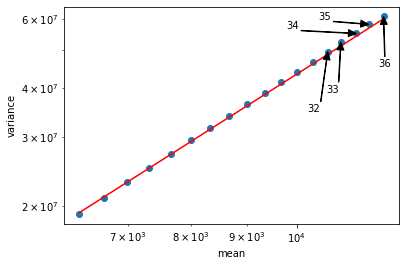

In [54]:
import scipy.stats as stats
b, a, r_value, p_value, std_err = stats.linregress(np.log(means), np.log(variances))

fig, ax = plt.subplots(1)
plt.scatter(means[18:], variances[18:])
plt.plot(means[18:], np.exp(a) * means[18:] ** b, color='red')
ax.set_yscale("log")
ax.set_xscale("log")
plt.xlabel("mean")
plt.ylabel("variance")

plt.annotate(text=36, xy=(means[-1], variances[-1]), xycoords = "data", xytext=(-5, -50), textcoords="offset points", arrowprops = dict(facecolor='black', width=0.5, headwidth=7, headlength=8))
plt.annotate(text=35, xy=(means[-2], variances[-2]), xycoords = "data", xytext=(-50, 5), textcoords="offset points", arrowprops = dict(facecolor='black', width=0.5, headwidth=7, headlength=8))
plt.annotate(text=34, xy=(means[-3], variances[-3]), xycoords = "data", xytext=(-70, 5), textcoords="offset points", arrowprops = dict(facecolor='black', width=0.5, headwidth=7, headlength=8))
plt.annotate(text=33, xy=(means[-4], variances[-4]), xycoords = "data", xytext=(-15, -50), textcoords="offset points", arrowprops = dict(facecolor='black', width=0.5, headwidth=7, headlength=8))
plt.annotate(text=32, xy=(means[-5], variances[-5]), xycoords = "data", xytext=(-20, -60), textcoords="offset points", arrowprops = dict(facecolor='black', width=0.5, headwidth=7, headlength=8))

plt.show()

The adapted allometric aggregation algorithm works as follows. For every segment size n, equally sized segments are extracted from the original sequence. Instead of taking steps of size n to select the next segment (containing n samples), ensuring that non-overlapping segments were formed in the original algorithm, a new variable step is now introduced in the implementation. This variable allows for **partial overlap** of the selected segments. As before, all counts in each segment are summed up, creating a new sample in the aggregated sequence representative for scale n. 

By allowing the segments to partially overlap, the last segment will not simply contain all leftover counts. Note that if step would be set equal to 1, N-n+1 segments of exactly size n would be created. For large values of n, this is much larger than the N/n segments (of which one segment will usually be smaller than the others) created in the original algorithm. This is good, since it allows for a better estimation of the variance for the current aggregation scale. However, this translates into much larger computation times: the updated algorithm would have a time complexity which is almost quadratic in the length N of the sequence. Of course, there are a lot of parallelisation opportunities in the implementation of the algorithm, but it also raises the question whether that many segments are even needed. By setting the step parameter to n/16 instead of 1, up to 16 times as many segments are created (only for higher values of n, which were the problematic scales in the previous method) compared to the original algorithm. This means that 16 times as many samples are used to estimate the mean and variance compared to before, while the computational complexity does not increase as much. 

Notably, the last segment will contain at least 15/16 times n samples, which is very close to the target size of n samples, and for this reason the variance will barely be impacted by the fact that the last segment does not contain as many samples as the others. This is shown in the plot above: by allowing the segments to overlap, it is ensured that much more segments can be used to estimate the variance in a certain aggregation step. All segments are almost fully filled up, meaning the last segment will not mess with the variance as before. For example, when n is equal to 33, 129 segments are extracted (compared to only 9, as before), with the last segment containing 32 samples (compared to only 24, as before). This results in a more reliable estimation of the variance and mean, and results in a more stable method to estimate the fractal dimension. 

## Final comparison

We conclude with a final comparison of the application of the original allometric aggregation method and the AAA method to a 3-day activity sequence, with maximal scale set to 9 hours. This represents the consecutive applications of the method which are executed in the complexity_evolution method, when a window of 3 days is set and n_max is equal to 9 times 60 (the settings we used to obtain our evolutions of the fractal dimension). 

In [55]:
counts_3days = np.array(df["2021-03-22 06:00":"2021-03-25 05:55"]["counts"])

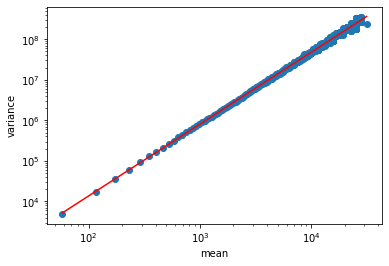

In [56]:
fractal_dim = complexity.allometric_aggregation(counts_3days, 9*60)

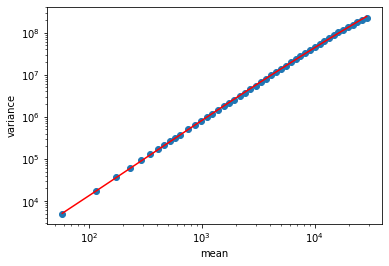

In [57]:
fractal_dim, scales = complexity.adapted_allometric_aggregation(counts_3days, 1, 9*60)

This once again illustrates the instability of the original allometric aggregation method when the n_max parameter (9 hours) approaches the same order of magnitude of the full length of the time series (3 days). The datapoints on the first plot are "frayed out" due to the issue with the partially filled segments. The estimation of the slope in the first plot inaccurately reflects the fractal scaling behaviour for those higher scales due to this artefact. In the second plot, these artefacts are gone, due to the changes implemented in the AAA method. The polynomial also bends down towards the end, which reflects the lower slope that is obtained for those higher scales. This was not possible with the original AA method. 